# U.S. Alternative Fuel Stations Development and Forecasts

### 2818879

### 02.04.2024

## 1. Introduction

Anthropogenic warming has become one of the most serious climate problems in the world today. The United States, as one of the world's largest carbon emitters, has some responsibility in the problem. According to the U.S. Environmental Protection Agency's (EPA) 2024 National Emissions Inventory (NEI), the most significant source of greenhouse gases in the U.S. is the transport sector, which emits a total of 1,780,763kt of carbon dioxide gases in 2022, which accounts for 35.2% of the total emissions (EIA, 2024). In response, the US has taken a number of measures to reduce GHG emissions from the transport sector. For example, encouraging the replacement of conventional diesel with renewable diesel (RD), which consumed a total of 9.6 billion gallons of RD in the US in 2020 (Yang et al., 2024). Encourage electric and hybrid vehicles (EHVs) as an environmentally friendly alternative to conventional gasoline-powered vehicles, with U.S. sales of hybrid electric vehicles (HEVs) growing from 268,749 to 798,992, plug-in hybrid electric vehicles (PHEVs) growing from 7,671 to 173,457, and plug-in electric vehicles ( PEVs) increased from 10,092 units to 459,426 units (Squalli, 2024). The transport sector's greenhouse gas emissions from electricity consumption will increase by less than 0.5 kt in 2021 compared to 2005 (EIA, 2024).

As an infrastructure in the transport system, Alternative Fuel Stations are an important part of the popularisation of new energy vehicles. The purpose of this analysis is to find out the factors affecting the popularity of new energy vehicles by studying the layout of Alternative Fuel Stations in the United States. It is also hoped that the existing Alternative Fuel Stations can be used to predict the future development trend of Alternative Fuel Stations, so as to give some suggestions to encourage the popularity of new energy vehicles and reduce the problem of climate warming. Spatial analysis was used to analyse the site layout. In predicting the development trend, time series prediction was used.



## 2. Data

### 2.1 Data presentation

This analysis was conducted by calling an API provided by NREL (National Renewable Energy Laboratory) to obtain data on alternative fueling stations in the United States. This database was chosen because it not only contains the most comprehensive information possible on alternative fueling stations in the United States. Existing stations in the database are also contacted at least once a year on an established schedule to verify that they are still operating and providing the specified fuel. Once stations are found to be no longer in operation or no longer offering alternative fuels, they are removed from the database. As a result, the data in the database are more accurate and comprehensive.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import requests
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
import contextily as ctx
import geopandas as gpd
from shapely.geometry import box
from shapely.geometry import Point
from keras.models import Sequential
from keras.layers import Dense, LSTM;

In [2]:
url = 'https://developer.nrel.gov/api/alt-fuel-stations/v1.json'
params = {
    'api_key': 'F4XSSLaZdCl8YMKFt36e4ldsFb6vgZp3HKRSGpsP',
    'country': 'US'
}

response = requests.get(url, params=params)

if response.status_code == 200:
    data = response.json()
    # Convert JSON data to DataFrame
    df = pd.DataFrame(data['fuel_stations'])
    # Save the DataFrame as a CSV file
    df.to_csv('Alternative_fuel_stations.csv', index=False)
# Extract the specified columns and generate a new DataFrame
df = df[['state', 'access_code', 'open_date', 'fuel_type_code','status_code', 'facility_type','latitude','longitude']]

### 2.2 Data Cleaning

The next step is to clean and filter the data by the first operation time. On the one hand, we need to clean out the data whose first operation time is empty, and on the other hand, we select the data before 2024.01.31, because the database is not updated very frequently, and the recent data may not be updated in time and lead to less accurate.

In [3]:
# Create a copy of the DataFrame and convert the open_date column to a datetime type
df = df.copy()
df['open_date'] = pd.to_datetime(df['open_date'])

# Create a boolean index to select rows that satisfy the condition (open_date is less than or equal to '2024-01-31' and open_date is not null)
condition = (df['open_date'] <= '2024-01-31') & (~df['open_date'].isnull())

# Remove rows that fulfil the conditions
df = df[condition]

# Get the time range of the open_date column
min_date = df['open_date'].min()
max_date = df['open_date'].max()

print("The open_date column ranges in time from", min_date, "to", max_date)


The open_date column ranges in time from 1976-01-02 00:00:00 to 2024-01-31 00:00:00


The data is then cleaned by adding the US boundary data. During the process of data entry, the data entered may be inaccurate for different reasons. The generated points are not within the US borders, which is obviously not common sense, and therefore the data needs to be filtered out.

In [4]:
#creating geodataframe

gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df['longitude'], df['latitude']))

In [5]:
gdf.head()

,state,access_code,open_date,fuel_type_code,status_code,facility_type,latitude,longitude,geometry
0,AL,private,2010-12-01,CNG,E,STANDALONE_STATION,32.367916,-86.267021,POINT (-86.26702 32.36792)
1,GA,private,1996-12-15,CNG,E,FLEET_GARAGE,33.821911,-84.367461,POINT (-84.36746 33.82191)
2,GA,private,1997-01-01,CNG,E,STANDALONE_STATION,33.760256,-84.543822,POINT (-84.54382 33.76026)
3,AR,public,1997-01-01,CNG,E,UTILITY,35.362213,-94.375338,POINT (-94.37534 35.36221)
4,MA,public,1996-11-15,CNG,E,AIRPORT,42.374706,-71.026549,POINT (-71.02655 42.37471)


In [6]:
gdf.set_crs(epsg=4326, inplace=True)
print(gdf.crs)

EPSG:4326


In [7]:
# Read the shapefile
os_data = gpd.read_file('/Users/wangyifan/Desktop/Python/cb_2018_us_state_5m/cb_2018_us_state_5m.shp')

In [8]:
#check the CRS
os_data.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

<Axes: >

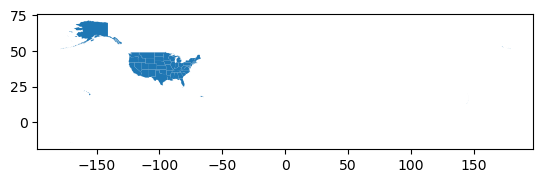

In [9]:
os_data.plot()

In [10]:
# Spatial connections made
gdf = gpd.sjoin(gdf, os_data.to_crs(epsg=4326), how='inner', predicate='within')


In [11]:
gdf = gdf.iloc[:, :9]

### 2.3 Data description

After screening and cleaning, the dataset contains information on a total of 80,120 alternative fuel stations in the United States from 1976.01.02 to 2024.01.31. The dataset contains information on alternative fueling stations in eight areas, including the state where they are located, the type of fuel offered, the time they first opened, the nature of the ownership, the type of facility, the status of the operation, and the longitude and latitude.

In [12]:
len(gdf)

80120

In [13]:
gdf.head()

,state,access_code,open_date,fuel_type_code,status_code,facility_type,latitude,longitude,geometry
0,AL,private,2010-12-01,CNG,E,STANDALONE_STATION,32.367916,-86.267021,POINT (-86.26702 32.36792)
30,AL,private,1998-09-15,CNG,E,OFFICE_BLDG,30.689832,-88.108861,POINT (-88.10886 30.68983)
224,AL,private,1999-07-08,LPG,E,FUEL_RESELLER,31.912022,-85.150318,POINT (-85.15032 31.91202)
225,AL,public,1999-07-08,LPG,E,FUEL_RESELLER,33.642079,-85.828466,POINT (-85.82847 33.64208)
226,AL,public,1999-07-08,LPG,E,FUEL_RESELLER,33.921589,-85.620314,POINT (-85.62031 33.92159)


These alternative fuel filling stations are divided into eight categories depending on the fuels provided.

1.BD - Biodiesel (B20 and above)

2.CNG--Compressed Natural Gas (CNG)

3.ELEC--Electric

4.E85--Ethanol (E85)

5.HY--Hydrogen

6.LNG--Liquefied Natural Gas (LNG)

7.LPG--Propane (LPG)

8.RD--Renewable Diesel (R20 and above)

The maximum number of charging stations is 69,010 and the minimum number of hydrogen charging stations is only 84.And it is easy to see through Figure.2 that most of the alternative fuel filling stations are mainly managed and operated by the public sector. This may be due to the fact that alternative fuel filling stations are seen as part of public service delivery, and their construction contributes to reducing the demand for conventional fuels and reducing the environmental and public health impacts of vehicle emissions. This is particularly true of stations such as Renewable Diesel, which are difficult to build and involve high investment, and which are managed by the public sector in 99.8 per cent of cases.

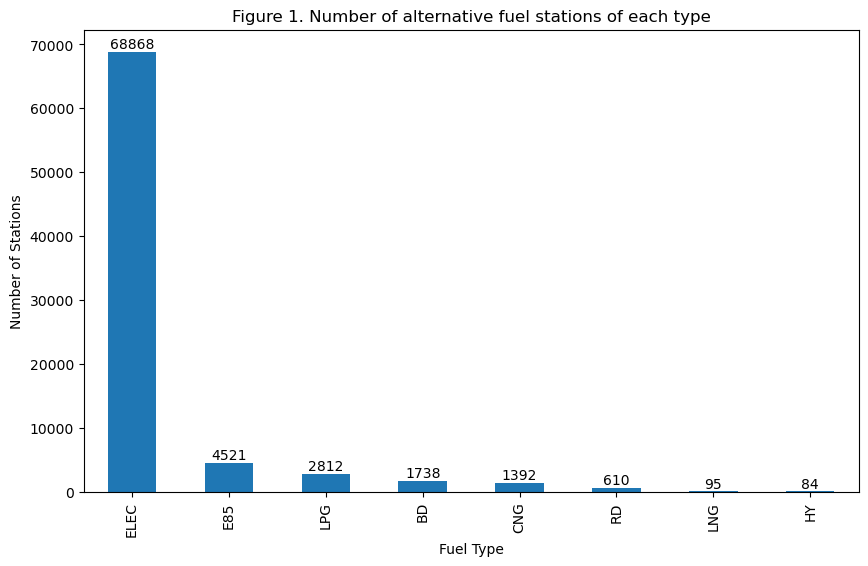

In [15]:
# of each alternative fuel station counted
fuel_type_counts = gdf['fuel_type_code'].value_counts()

# Drawing bar graphs
plt.figure(figsize=(10, 6))
fuel_type_counts.plot(kind='bar', title='Figure 1. Number of alternative fuel stations of each type')

for i, count in enumerate(fuel_type_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

# Add tags
plt.xlabel('Fuel Type')
plt.ylabel('Number of Stations')

# Display graphics
plt.show()

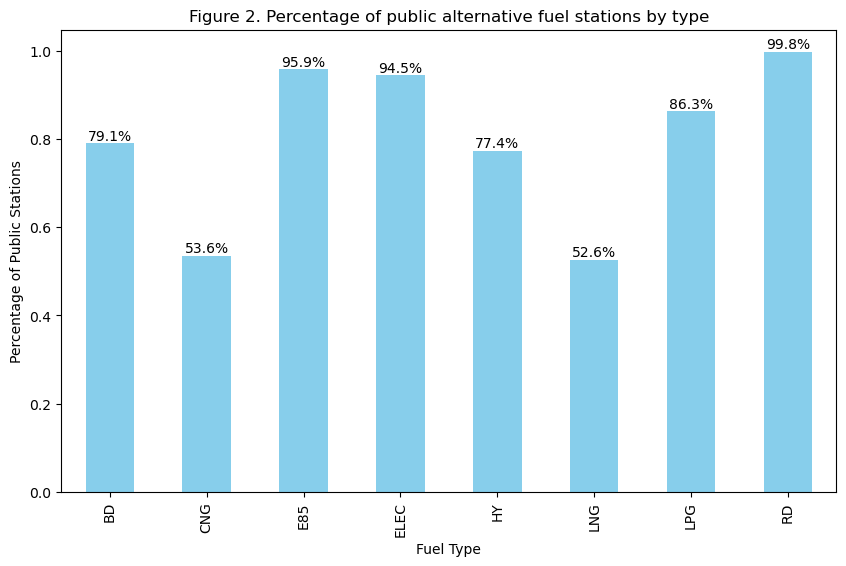

In [16]:
# of each alternative fuel station counted
fuel_type_counts = df['fuel_type_code'].value_counts()

# of each fuel type counted under different access_code categories
fuel_type_counts_by_access_code = df.groupby(['fuel_type_code', 'access_code']).size().unstack()

# of petrol stations with PUBLIC access rights calculated for each fuel type
public_counts = fuel_type_counts_by_access_code['public'].fillna(0)

#  Calculate the number of all petrol stations in each fuel type
total_counts = fuel_type_counts_by_access_code.sum(axis=1)

# Calculate the percentage of petrol stations with PUBLIC access for each fuel type
public_percentages = public_counts / total_counts

# Drawing bar graphs
plt.figure(figsize=(10, 6))
public_percentages.plot(kind='bar', color='skyblue', title='Figure 2. Percentage of public alternative fuel stations by type')

# Mark the scale on each column
for i, value in enumerate(public_percentages):
    plt.text(i, value, f'{value:.1%}', ha='center', va='bottom')

# Add tags
plt.xlabel('Fuel Type')
plt.ylabel('Percentage of Public Stations')

# Display graphics
plt.show()

## 3. Distribution of alternative fuel stations

### 3.1 Overview of the distribution of alternative fuel stations

Each point in Figure 3 represents the location of an alternative fueling station, while the edge histogram shows the distribution of these stations in latitude and longitude. It is easy to see from the scatterplot that these stations are very concentrated on both sides of the coastline, which is a densely populated and economically developed area of the United States. The histogram reveals some trends: the latitude histogram (left) shows that most of the gas stations are located between 30° and 50° latitude. The histogram of longitude (top) shows that gas stations are less dense in the west-central part of the continental United States and more concentrated in the eastern part of the country, which may be due to topographical factors in the United States, where areas with fewer alternative-fuel stations tend to have mountainous terrain.

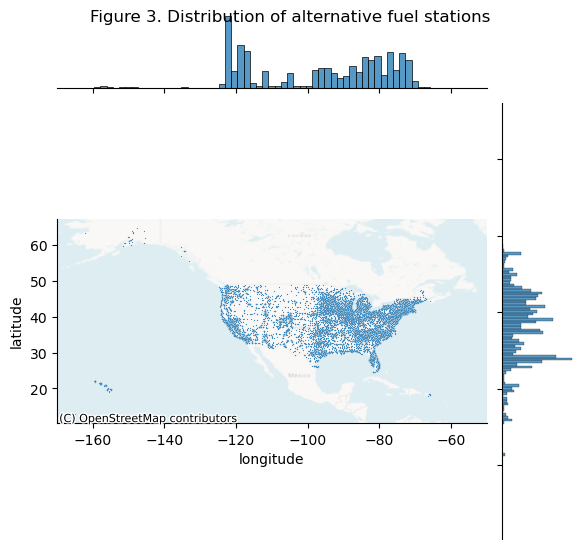

In [17]:
# Create an associated jointplot
df_plot = sns.jointplot(x='longitude', y='latitude', data=df, s=0.7)

# Add base maps
ctx.add_basemap(df_plot.ax_joint, crs="EPSG:4326",
                 source=ctx.providers.OpenStreetMap.Mapnik, alpha=0.4)

# 将经度限制在-150到-50
df_plot.ax_joint.set_xlim(-170, -50)

# Add title
plt.suptitle('Figure 3. Distribution of alternative fuel stations')

plt.show()


### 3.2 Distribution of alternative fuel stations between different states

As can be seen in Figure 4, four of the top five states in terms of the number of alternative fuel gasoline stations are among the top five states in the nation in terms of population size and economic size, which represents a direct relationship between the size of the economy and population for the number of alternative fuel gasoline stations. Of these states, California leads the way in the number of alternative fuel filling stations. Massachusetts is not in the top five states in terms of population or economic size, but it has a significant number of alternative fuel stations. This shows that these two states attach great importance to new energy sources, and their advanced policies and experiences are worth learning from other states. As for the states ranked in the bottom five in terms of the number of alternative fuel filling stations, except for Puerto Rico, the remaining four states may not be suitable for the development of new energy vehicles. Alaska is too high in latitude and has low temperatures that affect electric vehicle range. Montana, North Dakota and Wyoming are all located in the interior of the United States, far from the coastline, and are part of the Midwest region of the United States. All of these states contain a portion of the Rocky Mountains as a geographic feature with complex road conditions.

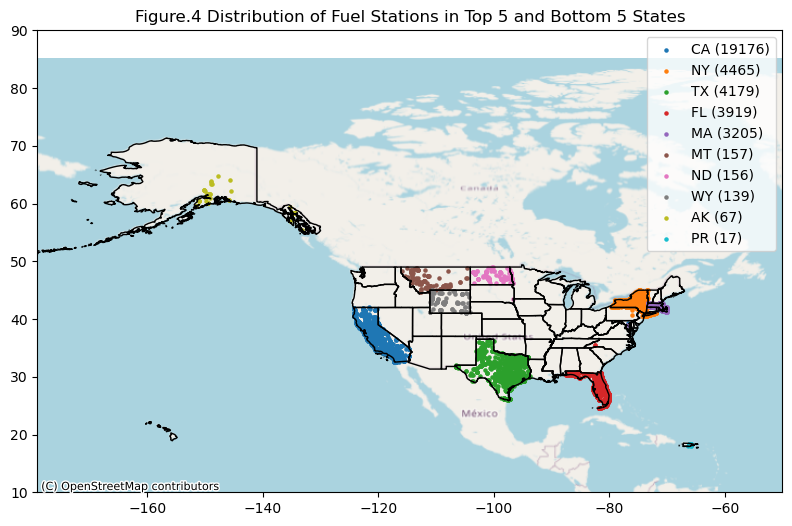

In [18]:
# Create charts and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Top 5 states with the highest number of access points
top_5_states = gdf['state'].value_counts().head(5).index

# Last 5 states with the lowest number of access points
bottom_5_states = gdf['state'].value_counts().tail(5).index

# Create colour maps
cmap = plt.get_cmap('tab10')  # Use tab10 colour mapping, you can also choose other colour mappings
colors = [cmap(i) for i in range(10)]

# Set the size of the point
markersize = 5

# of points in the top 5 states with the highest number of points plotted
for state, color in zip(top_5_states, colors[:5]):
    # Count the number of data in each state
    count = len(gdf[gdf['state'] == state])
    # Draw the point and set the size of the point
    gdf[gdf['state'] == state].plot(ax=ax, color=color, markersize=markersize, label=f'{state} ({count})')

# Plotting points in the last 5 states with the lowest number of points
for state, color in zip(bottom_5_states, colors[5:]):
    # Count the number of data in each state
    count = len(gdf[gdf['state'] == state])
    # Draw the point and set the size of the point
    gdf[gdf['state'] == state].plot(ax=ax, color=color, markersize=markersize, label=f'{state} ({count})')

# Mapping of state boundaries
os_data.plot(ax=ax, color='none', edgecolor='black')

# Add title
ax.set_title('Figure.4 Distribution of Fuel Stations in Top 5 and Bottom 5 States')

# Add legend
plt.legend()

# Limit x-axis range
ax.set_xlim(-179, -50)
ax.set_ylim(10, 90)

# Add base maps
ctx.add_basemap(ax=ax, crs="EPSG:4326", source=ctx.providers.OpenStreetMap.Mapnik, alpha=1)
    
# Display graphics
plt.show()

### 3.3 Distribution of different alternative fuel stations in the United States

As can be seen in Figure 5, although there are different types of fuels, the distribution is concentrated along the coast and less in the Midwest. Figure 6 shows that gas stations for all fuels are located along the California coast and are more densely populated than elsewhere. In particular, renewable diesel fueling stations are almost non-existent elsewhere. On the one hand, because California has been a leader in environmental protection, the government has enacted a series of regulations and policies to encourage the use of renewable energy. It also has very strict emission standards for diesel vehicles. On the other hand California has been a leader in technological innovation, and that includes the energy sector. Many gas stations may be experimenting with new technologies and forms of energy, including renewable diesel, etc. E85 stations are relatively abundant in the Midwest, which may be related to the ability of local agriculture to produce ethanol. Biodiesel fueling stations are relatively more concentrated in the central and northeastern United States. Compared to the previous distribution of E85 fueling stations, the distribution of BD fueling stations appears to be more concentrated and not spread across the entire country. This distribution pattern may reflect regional differences in biodiesel production, demand, and policy support.

Compared to other energy sources, EV charging infrastructure is more widespread across the United States. On the one hand, the use of electric vehicles is becoming more popular due to the continuous development of EV technology and cost reductions. This has prompted more companies to invest in charging infrastructure to meet the market demand. On the other hand charging infrastructure has a smaller footprint and investment. Charging stations can be arranged more flexibly within cities and can be constructed in more locations than traditional petrol stations, including shopping centres, car parks, restaurants and other locations, making the charging of electric vehicles more convenient and accessible.

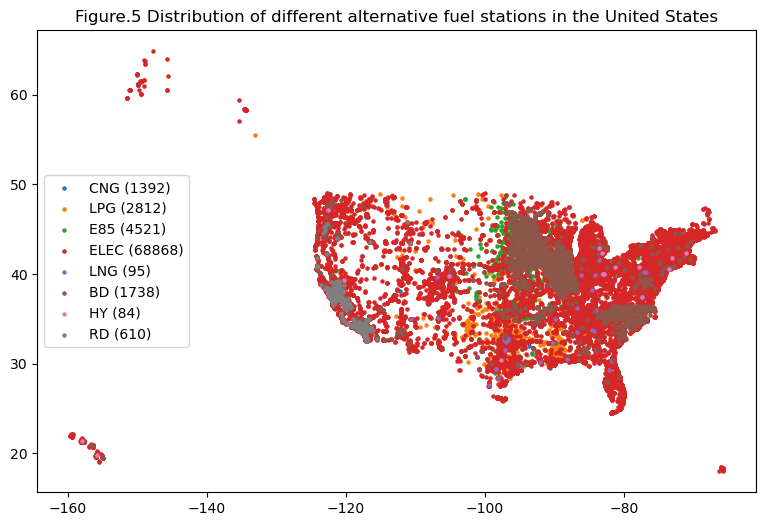

In [19]:
# Create charts and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Get unique fuel_type_code value
fuel_type_codes = gdf['fuel_type_code'].unique()

# Create colour maps
cmap = plt.get_cmap('tab10')  # Use tab10 colour mapping, you can also choose other colour mappings
colors = [cmap(i) for i in range(len(fuel_type_codes))]
color_map = dict(zip(fuel_type_codes, colors))

# Set the size of the point
markersize = 5

# Plot different coloured dots based on different values of fuel_type_code
for fuel_type_code, color in color_map.items():
    # Count the number of data for each fuel_type_code
    count = len(gdf[gdf['fuel_type_code'] == fuel_type_code])
    # Draw the point and set the size of the point
    gdf[gdf['fuel_type_code'] == fuel_type_code].plot(ax=ax, color=color, markersize=markersize, label=f'{fuel_type_code} ({count})')

# Add title
ax.set_title('Figure.5 Distribution of different alternative fuel stations in the United States')

# Add legend
plt.legend()

# Add graphics
plt.show()


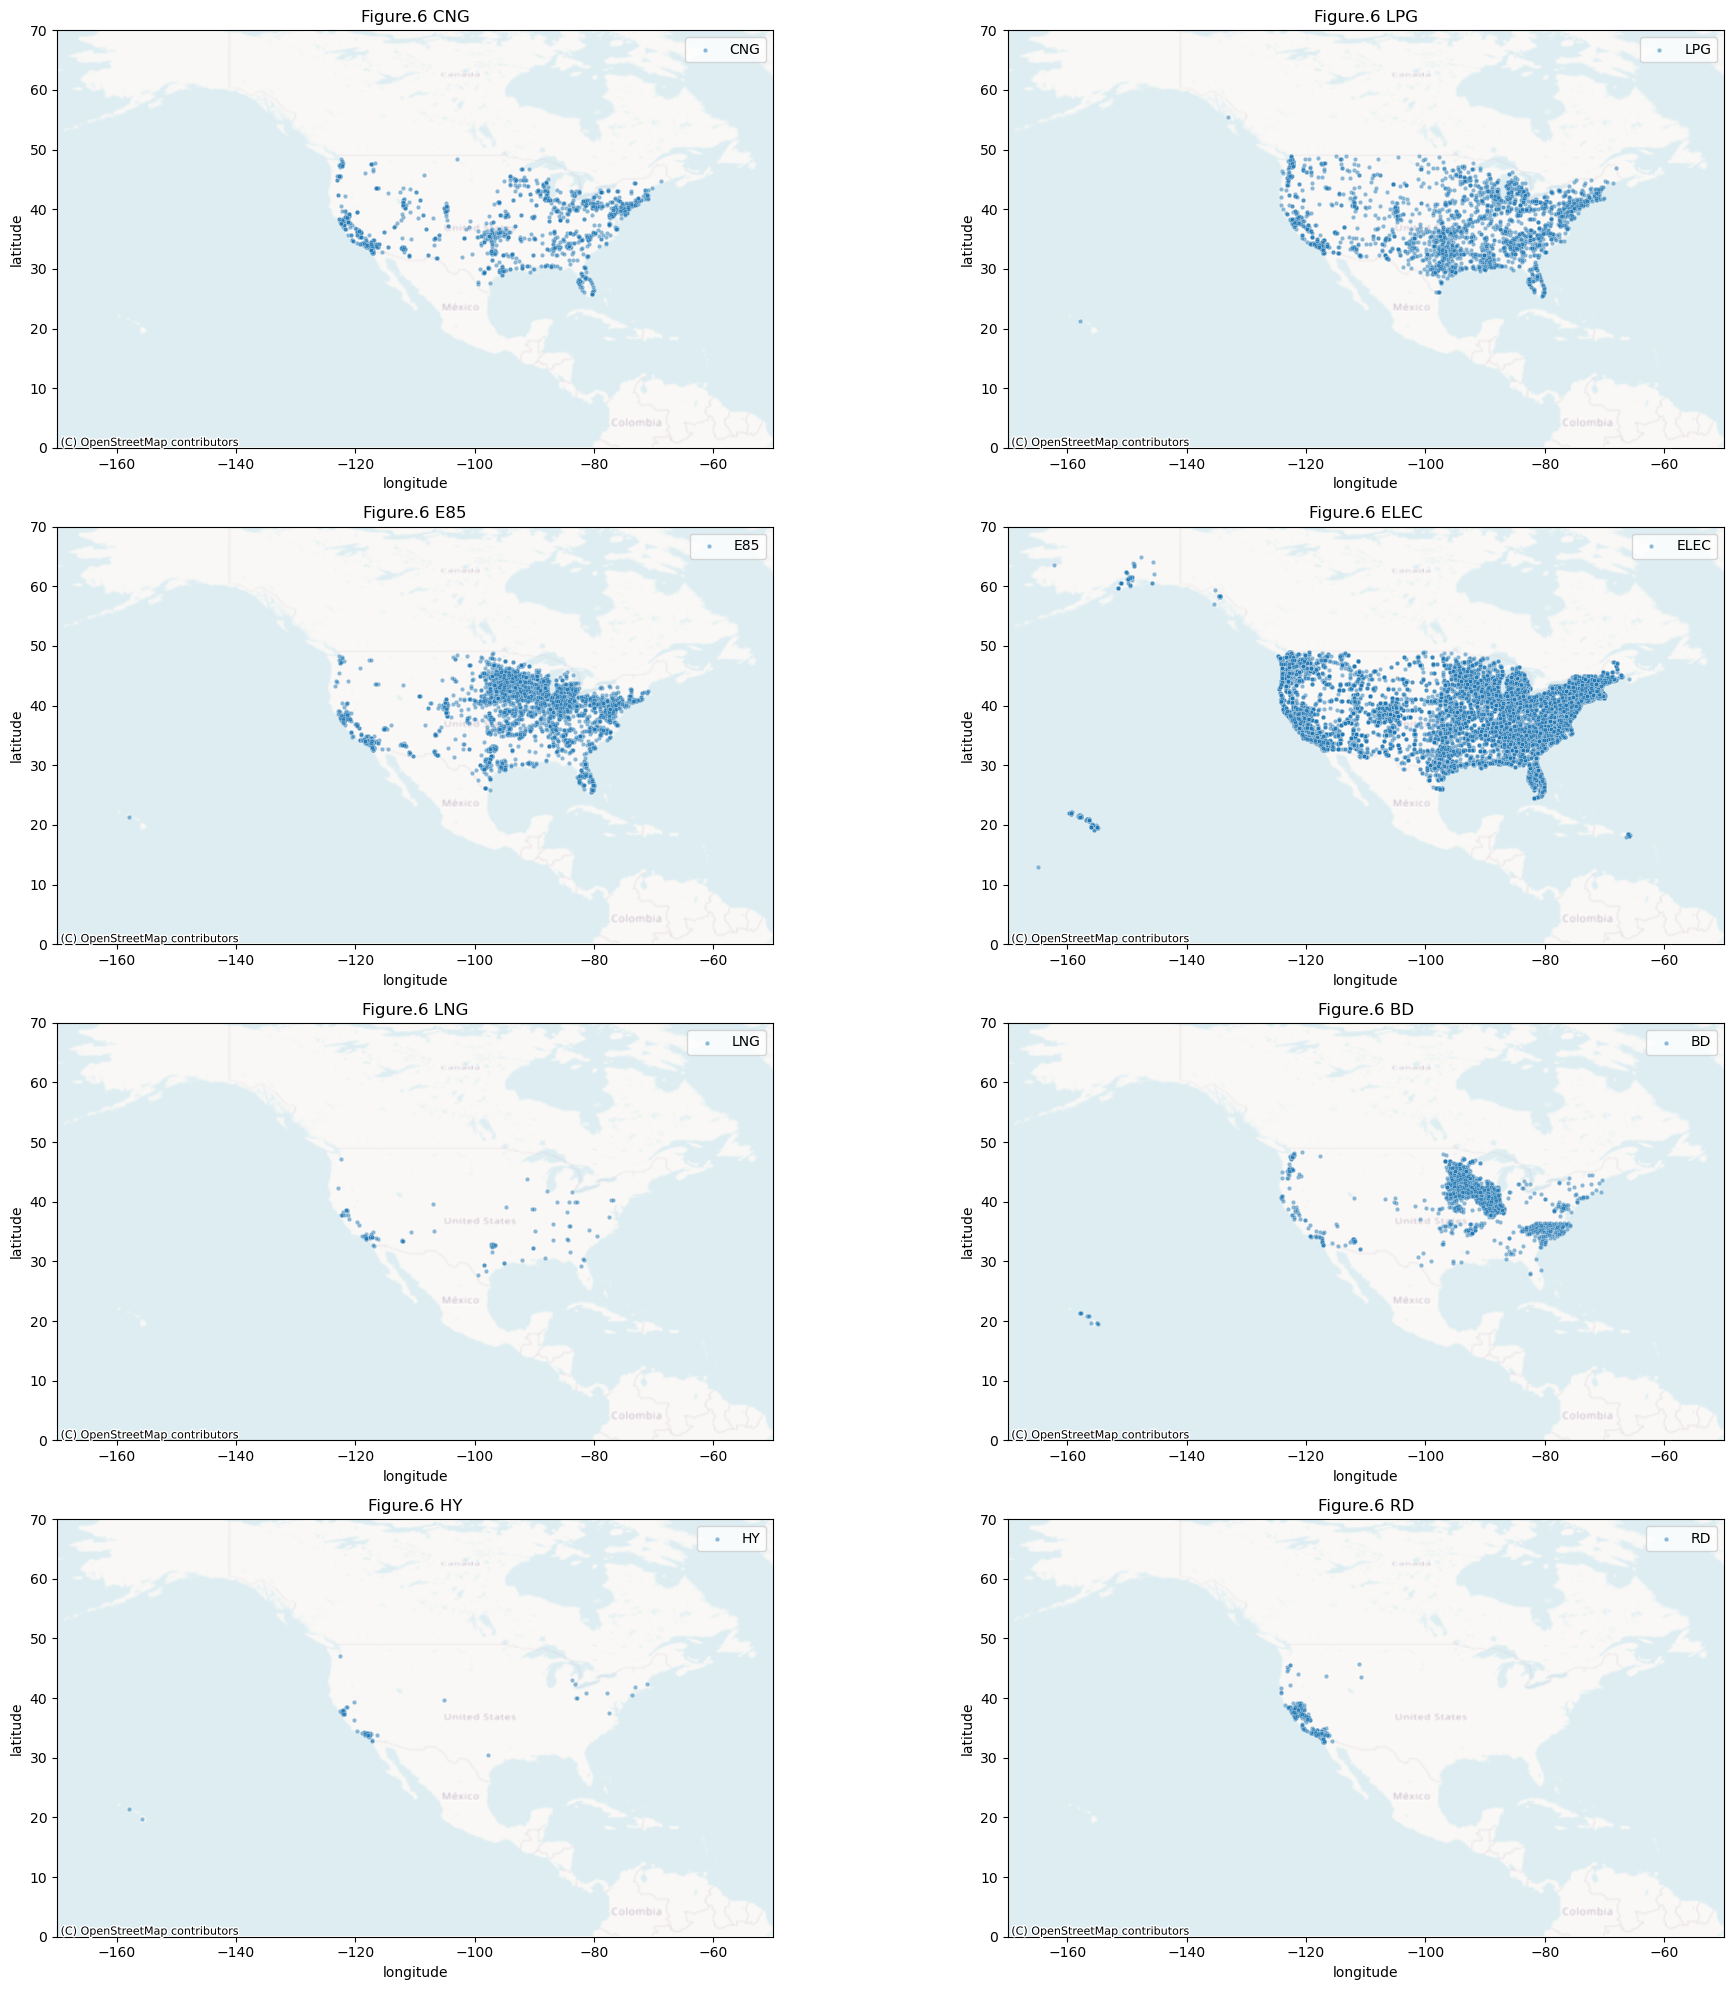

In [21]:
# Getting Unique Values
fuel_type_codes = gdf['fuel_type_code'].unique()

# Set the number of rows and columns of the subgraphs
num_rows = 4
num_cols = 2

# Create charts and axes while resizing small graphs
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))

for i, fuel_type_code in enumerate(fuel_type_codes):
    # Calculate the row and column numbers of the subplot
    row = i // num_cols
    col = i % num_cols
    
    # Get the data corresponding to the current fuel_type_code
    data = df[df['fuel_type_code'] == fuel_type_code]
    
    # Draw the point of the current fuel_type_code and set transparency
    sns.scatterplot(x='longitude', y='latitude', data=data, ax=axes[row, col], s=10, label=f'{fuel_type_code}', alpha=0.5)
    
    # Setting latitude and longitude ranges
    axes[row, col].set_xlim(-170, -50)
    axes[row, col].set_ylim(0, 70)
    
    # Add base maps
    ctx.add_basemap(ax=axes[row, col], crs="EPSG:4326", source=ctx.providers.OpenStreetMap.Mapnik, alpha=0.4)
    
    # Add Title
    axes[row, col].set_title(f'Figure.6 {fuel_type_code}')

# Adjustment of sub-map layout
plt.tight_layout()

# Display graphics
plt.show()


### 3.4 Layout of facilities near alternative fuel stations

As can be seen in Figure 7. Convenience stores have the highest number of alternative fuel refuelling stations near them, which may be due to the fact that convenience stores are usually located in densely populated or heavily trafficked areas, and therefore establishing alternative energy refuelling stations in these places can better meet people's energy needs. People can also stop by to recharge their batteries or refuel with hydrogen when they visit a convenience store to buy everyday items, which increases traffic to alternative energy fuelling stations. Next in line are car dealerships and hotels, probably because they are often located along major traffic arteries or motorways, which are also ideal locations for people to make stopovers on long journeys. Establishing alternative energy fueling stations at these locations can provide convenient charging or hydrogen refuelling services for those car owners who are on long journeys.
Seven of the top ten facility types are in public locations. This may be partly due to the fact that public places are usually located in densely populated areas, such as commercial centres and car parks, where there is a high volume of people and traffic. On the other hand, it may be due to the fact that the presence of alternative energy petrol stations in close proximity to public places helps to promote sustainable mobility. Public places are often places where people congregate and where vehicle owners stay for longer periods of time, so the provision of alternative energy refuelling stations in these places can provide them with more choices and encourage them to choose vehicles that use alternative energy sources.

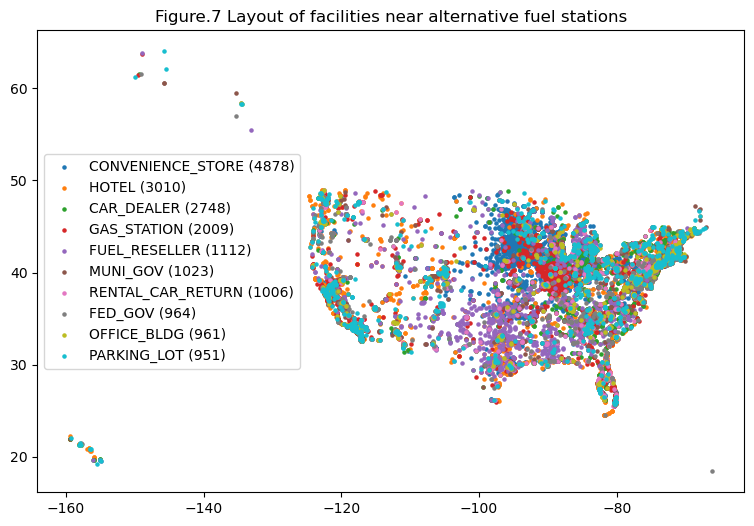

In [26]:
# Create charts and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Top 10 facility types with the highest number of access points
top_10_facility = gdf['facility_type'].value_counts().head(10).index

# Create colour maps
cmap = plt.get_cmap('tab10')  # Use tab10 colour mapping, you can also choose other colour mappings
colors = [cmap(i) for i in range(10)]

# Set the size of the point
markersize = 5

# Top 10 facility types with the highest number of points plotted
for facility, color in zip(top_10_facility, colors[:10]):
    # Count the number of data per facility
    count = len(gdf[gdf['facility_type'] == facility])
    # Draw the point and set the size of the point
    gdf[gdf['facility_type'] == facility].plot(ax=ax, color=color, markersize=markersize, label=f'{facility} ({count})')

# Add title
ax.set_title('Figure.7 jh')

# Add legend
plt.legend()

# Show charts
plt.show()


## 4. Forecasting trends in alternative energy stations through time series

### 4.1 Trends in alternative fuel station development

Firstly, the time period of the study was identified. Due to advances in technology and the times, this analysis uses data from the 21st century for the study. In this case, data from 2000 to 2023 was used to train the model and predict trends for 2024. Then, from the above analysis, it is clear that charging stations are the most numerous of the alternative fuel refuelling stations, so the study is divided into charging stations and other types of fuel refuelling stations.

As can be seen in Figure 8, the number of EV charging stations has steadily increased from around 2011,the number has rapidly increased in 2016, and the rate of increase has further increased to around 2021. In the initial stage (2011-2016), the number of EV charging stations shows a steady increase. This could be attributed to the popularity of electric vehicles and the construction of charging infrastructure driven by government policies, technological developments, and increased awareness of environmental protection. In the rapid growth phase (2016-2021), the number of EV charging stations starts to grow rapidly. Growth in this phase may be influenced by a number of factors, including increased sales of electric vehicles, government support and investment in renewable energy, improvements in charging technology, and corporate investment in the electric vehicle market. The spurt growth phase (2021-2023) sees a further increase in the growth rate of electric vehicle charging stations around 2021. This could be due to the further development and maturity of EV technology and the fact that EVs have opened up the market in the US, prompting more investors and companies to get involved in building EV charging infrastructure.

In [120]:
# Ensure that the date column is of datetime type
gdf['open_date'] = pd.to_datetime(gdf['open_date'])

# Use conditional filtering to select data within a time range
start_date = '2000-01-01'
end_date = '2023-12-31'
gdf_time = gdf[(gdf['open_date'] >= start_date) & (gdf['open_date'] <= end_date)]

In [117]:
# Delete rows in the fuel_type_code column that are not 'ELEC'
gdf_time1 = gdf_time[gdf_time['fuel_type_code'] == 'ELEC']

# Convert datetime columns to month format
gdf_time1['open_date'] = pd.to_datetime(gdf_time1['open_date'])
gdf_time1['month'] = gdf_time1['open_date'].dt.to_period('M')

# Use the groupby function to calculate the number of values for each month
gdf_time_E = gdf_time1.groupby('month').size().reset_index(name='count')

# Use the reindex method to fill in the missing months and set the value to 0
all_months = pd.period_range(start=gdf_time_E['month'].min(), end=gdf_time_E['month'].max(), freq='M')
gdf_time_E = gdf_time_E.set_index('month').reindex(all_months, fill_value=0).reset_index()

# Change the column name of the first column to 'month'
gdf_time_E = gdf_time_E.rename(columns={'index': 'month'})

# Show results
gdf_time_E.head()


,month,count
0,2000-04,3
1,2000-05,0
2,2000-06,0
3,2000-07,0
4,2000-08,0


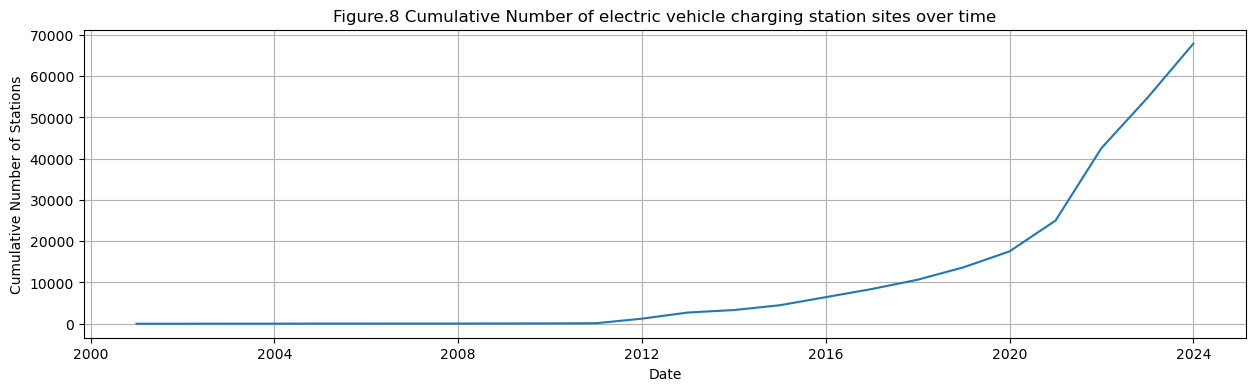

In [118]:
gdf_time_E['month'] = gdf_time_E['month'].dt.to_timestamp()
gdf_time_E.set_index('month', inplace=True)


def plot_cumulative_gdf_time_E(gdf_time_E, y, title="", xlabel='Date', ylabel='Cumulative Number of Stations', dpi=100):
    plt.figure(figsize=(15, 4), dpi=dpi)
    cumulative_counts = gdf_time_E[y].cumsum()
    cumulative_counts_resampled = cumulative_counts.resample('Y').last()  # Resampled to the last data point of each year
    years = pd.date_range(start='2000-01-01', end='2023-12-31', freq='Y')
    plt.plot(years, cumulative_counts_resampled, color='tab:blue')
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

plot_cumulative_gdf_time_E(gdf_time_E, y='count', title='Figure.8 Cumulative Number of electric vehicle charging station sites over time')


Unlike the growth curve of electric charging stations, other types of alternative fueling stations began to grow slowly in 2000 and slowly grew to 4,000 by about 15 years. The growth rate accelerates after 15 years to more than 10,000 by the end of 2023. However, there is still a large gap between its growth rate and that of charging stations.

This gap may be due to the higher maturity of EV technology and higher market demand. As electric vehicle technology continues to develop and mature, and the demand for environmentally friendly and sustainable travel increases, the demand for electric vehicle charging infrastructure increases accordingly. Other types of alternative fuel stations may be less affected by technology maturity and market demand, resulting in relatively lower growth rates.

In [126]:
# Delete the row with 'ELEC' in the fuel_type_code column
gdf_time2 = gdf_time[gdf_time['fuel_type_code'] != 'ELEC'].copy()

# Convert datetime columns to month format
gdf_time2['open_date'] = pd.to_datetime(gdf_time2['open_date'])
gdf_time2['month'] = gdf_time2['open_date'].dt.to_period('M')

# Create a period range containing all desired months
expected_months = pd.period_range(start='2000-01', end='2023-12', freq='M')

# Period ranges added to the dataset
gdf_time_O = pd.DataFrame({'month': expected_months})

# Calculate the number of values for each month using the merge and groupby functions
gdf_time_O = gdf_time_O.merge(gdf_time2.groupby('month').size().reset_index(name='count'), on='month', how='left').fillna(0)

# Convert the count column to an integer type
gdf_time_O['count'] = gdf_time_O['count'].astype(int)

# Show results
gdf_time_O.head();


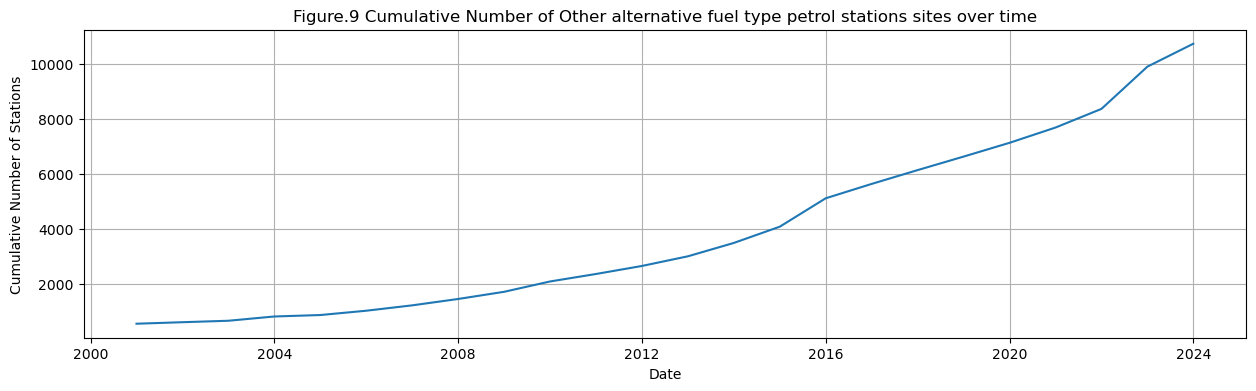

In [127]:
gdf_time_O['month'] = gdf_time_O['month'].dt.to_timestamp()
gdf_time_O.set_index('month', inplace=True)


def plot_cumulative_gdf_time_O(gdf_time_E, y, title="", xlabel='Date', ylabel='Cumulative Number of Stations', dpi=100):
    plt.figure(figsize=(15, 4), dpi=dpi)
    cumulative_counts = gdf_time_O[y].cumsum()
    cumulative_counts_resampled = cumulative_counts.resample('Y').last()  # Resampled to the last data point of each year
    years = pd.date_range(start='2000-01-01', end='2023-12-31', freq='Y')
    plt.plot(years, cumulative_counts_resampled, color='tab:blue')
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

plot_cumulative_gdf_time_O(gdf_time_O, y='count', title='Figure.9 Cumulative Number of Other alternative fuel type petrol stations sites over time')


### 4.2 Predictive modelling using electric vehicle charging stations as an example

Since the electric vehicle charging stations have been developing fast in recent years and there are more data, this paper uses the data of electric vehicle stations to build the prediction model.

As can be seen in Figure 8, there is a very rapid rise in EV charging stations in 2021. In order to reduce the fluctuation and noise of the data, to make the data smoother and easier to understand, and to help observe the long-term trends and cyclical changes in the data. I chose the exponential smoothing method to process the data. Due to the rapid increase in EV charging stations in recent years, I chose a larger α (0.2) to make the model less biased towards historical observations and more reflective of recent changes in the data.

As can be seen through Figure 10, the exponentially smoothed curve reduces the noise of the data to a large extent. In order to make the prediction line will follow the actual data points more closely, the dataset with an α value of 0.2 is still finally chosen as the dataset for building the prediction model.

In [195]:
# Create a new dataframe with only the 'count'
data_E = gdf_time_E.filter(['count'])
# Convert the dataframe to a numpy array
dataset_E = data_E.values

In [196]:
def exponential_smoothing(series, alpha):
    result = [series[0]]  # Use [0] to access the first element
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[-1])  
    return result


In [197]:
smoothed_data_E = exponential_smoothing(dataset_E, alpha=0.2)


In [198]:
def plotExponentialSmoothing(series, alphas):
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series, "c", label="Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("FIgure.10 Exponentially smoothed number of new EVCS curves")
        plt.grid(True);

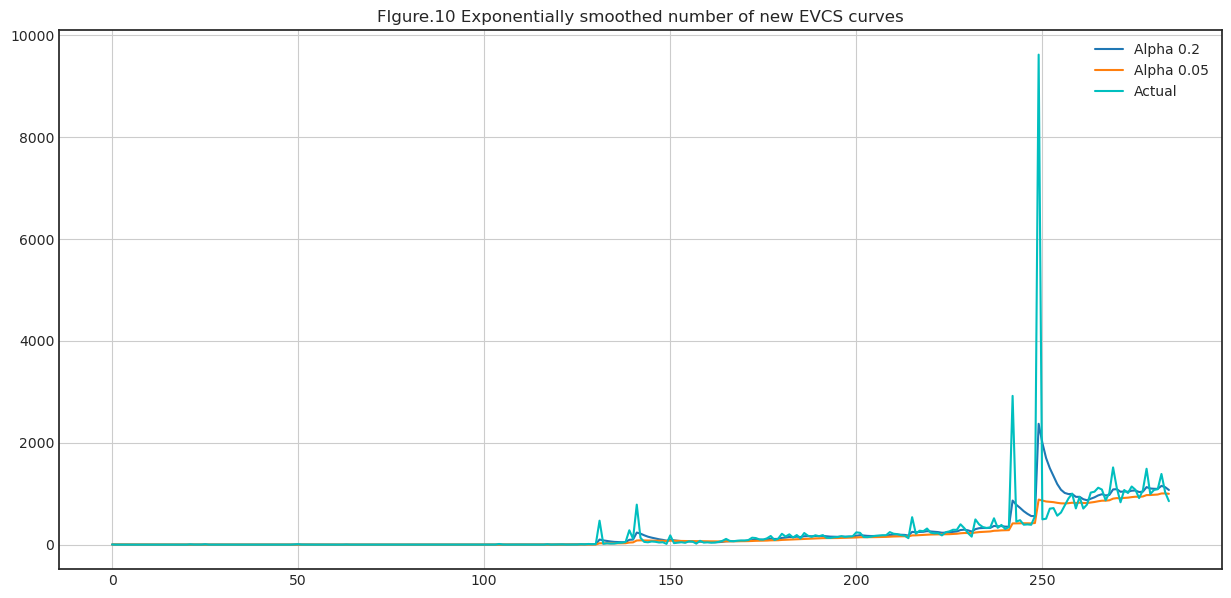

In [199]:
plotExponentialSmoothing(dataset_E, [0.2, 0.05])


In [208]:
data_smoothed_E = pd.DataFrame({'count': smoothed_data_E})


After taking 85% of the dataset for training the data is normalised to improve the training speed and performance of the model. The training dataset was then created and prepared into a format suitable for Recurrent Neural Network (RNN) training. A large time window (60) was chosen for prediction accuracy. Next a recurrent neural network (RNN) model was constructed using the Keras library. The performance of the trained model was then tested on the test dataset and the root mean square error of its predictions was calculated.
As can be seen in Figure 10, the model fits the training data well at most time points. However, at about position 250 on the time axis, there is a sharp fluctuation in the actual data, which is not accurately captured by the model's prediction. The reason for this fluctuation may be that the newly enacted policy at that time strongly encouraged the construction of new charging stations.

In [209]:
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(smoothed_data_E) * .85 ))

training_data_len

243

In [210]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(smoothed_data_E)

scaled_data;

In [211]:
# Create the training data set 
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# x_train.shape

[array([1.25069861e-03, 9.97682416e-04, 7.95269459e-04, 6.33339094e-04,
       5.03794802e-04, 4.00159368e-04, 3.17251021e-04, 2.50924343e-04,
       1.97863001e-04, 1.55413927e-04, 1.21454668e-04, 9.42872610e-05,
       7.25533353e-05, 5.51661947e-05, 4.12564822e-05, 3.01287122e-05,
       2.12264962e-05, 1.41047234e-05, 8.40730521e-06, 3.84937063e-06,
       2.03022959e-07, 5.03318337e-04, 4.84116928e-04, 3.84417069e-04,
       3.88995913e-04, 9.83030113e-04, 7.83547617e-04, 7.08300352e-04,
       5.63763808e-04, 4.48134573e-04, 3.55631185e-04, 2.81628474e-04,
       2.22426306e-04, 1.75064571e-04, 1.37175183e-04, 1.06863673e-04,
       8.26144650e-05, 6.32150985e-05, 4.76956052e-05, 3.52800106e-05,
       2.53475350e-05, 1.74015544e-05, 1.10447700e-05, 5.95934246e-06,
       1.89100043e-06, 8.29750588e-05, 6.35035735e-05, 4.79263853e-05,
       3.54646347e-05, 3.62850162e-04, 1.04645224e-03, 9.18624054e-04,
       7.32022769e-04, 5.82741742e-04, 4.63316920e-04, 3.67777063e-04,
     

In [212]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Input

# Create Sequential Models
model = Sequential()

# Add the first layer (input layer) of the LSTM model
model.add(Input(shape=(x_train.shape[1], 1)))

# Add LSTM layer
model.add(LSTM(128, return_sequences=True))

# Add LSTM layer
model.add(LSTM(64, return_sequences=False))

# Add full connection
model.add(Dense(25))

# Add an output layer
model.add(Dense(1))

# Compilation model
model.compile(optimizer='adam', loss='mean_squared_error')

# Training models
model.fit(x_train, y_train, batch_size=1, epochs=1)


183/183 [==============================] - 2s 8ms/step - loss: 9.7144e-04


In [213]:
# Create the testing data set
# Create a new array containing scaled values 
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = scaled_data[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

2/2 [==============================] - 0s 6ms/step


1061.3659147676774

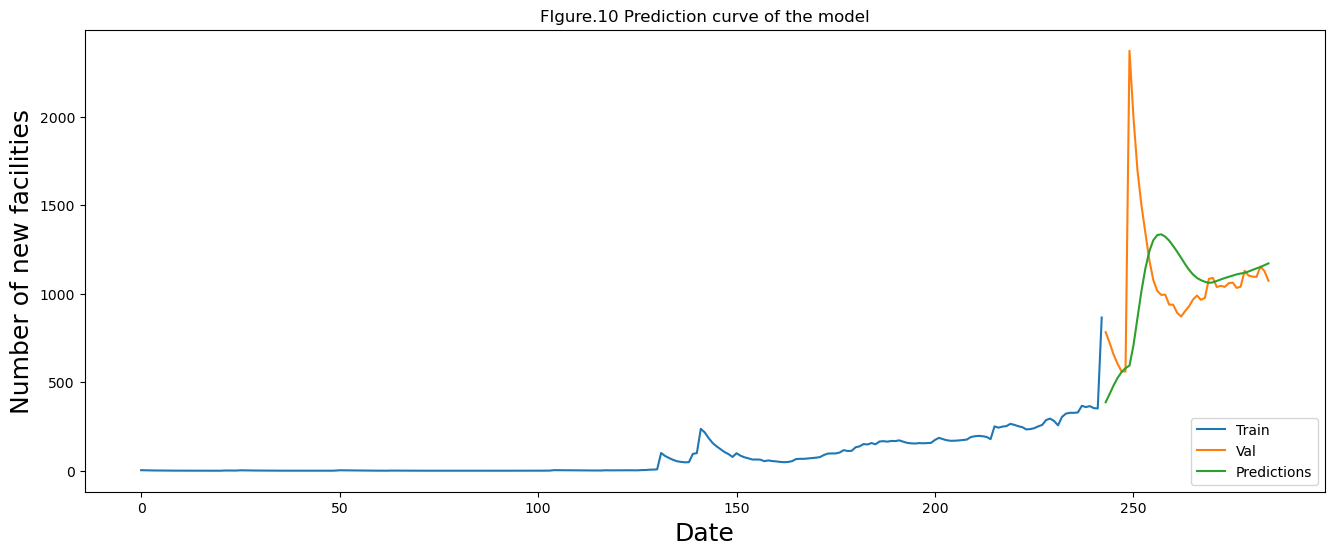

In [214]:
# Continue to use the previous data split
train = data_smoothed_E[:training_data_len]
valid = data_smoothed_E[training_data_len:].copy()  

# Use the .loc method to securely set the value of a new column
valid.loc[:, 'Predictions'] = predictions

# Visualisation data
plt.figure(figsize=(16,6))
plt.title('FIgure.10 Prediction curve of the model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Number of new facilities', fontsize=18)
plt.plot(train['count'])  
plt.plot(valid[['count', 'Predictions']])  
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()


Finally, the model above was applied to forecast new EV charging stations in 2024. Figure 12 shows that the number of new EV charging stations in the next 12 months is above 1,000 and is growing slowly. This is a small difference from the January 2024 number of 1,020 in the original dataset, so the model's predictions are reasonably accurate.
The reason for this growth is likely to be the fact that electric vehicles have become the preferred choice of more and more people, and the steady growth in demand for vehicles has led to a steady growth in demand for electricity.

In [219]:
# Take the last 20 rows of data_smoothed_E to form last_month_data dataset
last_20_data = data_smoothed_E.iloc[-20:].rename(columns={'count': 'count'})

# Pre-processing of data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_20_data = scaler.fit_transform(last_20_data)



In [220]:
# Initialise the empty list to hold the prediction data
predictions_data = []

# Add predictions to the dataset
for i in range(12):
    month = '2024-{}'.format(i + 1)
    
   # Take the last 20 months of data as inputs
    x_input = np.reshape(scaled_20_data, (1, 20, 1))

    # Make projections
    prediction = model.predict(x_input)
    
    # Add predictions to the list of predicted data
    prediction_value = scaler.inverse_transform(prediction)[0][0]
    predictions_data.append({'month': month, 'count': prediction_value})
    
    # Update the last 20 months of data to the current forecast for the next round of forecasting
    scaled_20_data = np.append(scaled_20_data[1:], prediction, axis=0)
    
    # Print current forecast results
    print("Month", i+1, "Prediction:", prediction_value)

# Convert a list of predictive data into a DataFrame
predictions_E = pd.DataFrame(predictions_data)



1/1 [==============================] - 0s 67ms/step
Month 1 Prediction: 1095.9115
1/1 [==============================] - 0s 9ms/step
Month 2 Prediction: 1100.0437
1/1 [==============================] - 0s 9ms/step
Month 3 Prediction: 1103.1218
1/1 [==============================] - 0s 8ms/step
Month 4 Prediction: 1105.7845
1/1 [==============================] - 0s 9ms/step
Month 5 Prediction: 1108.1116
1/1 [==============================] - 0s 7ms/step
Month 6 Prediction: 1109.8148
1/1 [==============================] - 0s 8ms/step
Month 7 Prediction: 1111.5327
1/1 [==============================] - 0s 7ms/step
Month 8 Prediction: 1113.5366
1/1 [==============================] - 0s 8ms/step
Month 9 Prediction: 1115.5101
1/1 [==============================] - 0s 9ms/step
Month 10 Prediction: 1117.5312
1/1 [==============================] - 0s 8ms/step
Month 11 Prediction: 1119.4711
1/1 [==============================] - 0s 8ms/step
Month 12 Prediction: 1121.4293


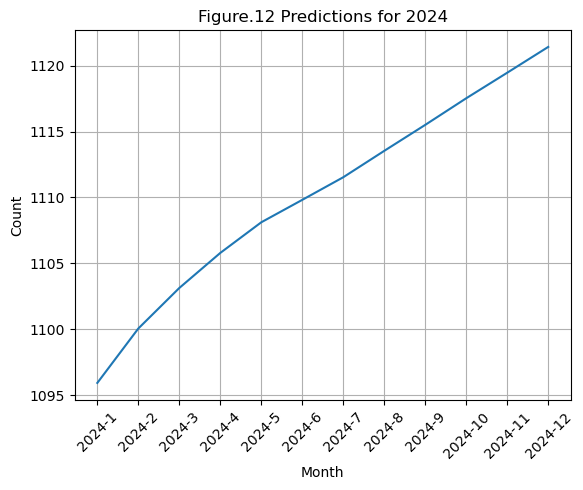

In [218]:
plt.plot(predictions_E['month'], predictions_E['count'])
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Figure.12 Predictions for 2024')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


## 5. Conclusion

By analysing the layout of alternative energy gas stations in the United States, this paper reveals the influencing factors of the popularity of new energy vehicles and tries to predict the future trend of gas station development. The main conclusions are as follows:

Alternative energy refuelling stations, as the infrastructure of the transport system, are crucial to the promotion of new energy vehicles. By analysing the spatial distribution of petrol stations, it is found that petrol stations are mainly concentrated in densely populated and economically developed coastal areas, while they are less distributed in inland areas. This distribution pattern has a certain relationship with the economy and population size. Meanwhile, common types of facilities around petrol stations, such as convenience stores, car dealerships and hotels, are usually located in areas with high pedestrian flow, providing more traffic to petrol stations.

The time series analysis reveals that the number of EV charging stations shows a trend of steady growth with a gradually accelerating growth rate. Compared with this, the growth rate of other types of alternative energy fuelling stations is slower and there is an obvious gap. A prediction model based on the exponential smoothing method predicts the future growth trend of electric vehicle charging stations, and the results show that the number of new charging stations will remain above 1,000 in the next 12 months, and show a slow growth trend. This prediction result provides a certain reference for the future development of new energy vehicles.

## Word count: 2905

## References

EPA (2024). Draft Inventory of U.S. Greenhouse Gas Emissions and Sinks: 1990-2022 U.S. Environmental Protection Agency, EPA 430-D-24-001. https://www.epa.gov/ghgemissions/draft-inventory-us-greenhouse-gas-emissions-and-sinks-1990-2022.

Zeyu Yang, Keval Shah, Charlotte Pilon-McCullough, Robert Faragher, Pervez Azmi, Bruce Hollebone, Ben Fieldhouse, Chun Yang, Diane Dey, Patrick Lambert, Vanessa Beaulac,2024.Characterization of renewable diesel, petroleum diesel and renewable diesel/biodiesel/petroleum diesel blends.Renewable Energy,Volume 224,120151,ISSN 0960-1481.

Squalli, J. (2024). Environmental hypocrisy? Electric and hybrid vehicle adoption and pro-environmental attitudes in the United States. Energy, p.130670.